# Using Labels and Defining Domains

Labels are a way to 'bookmark' certain pores for easier lookup later, such as specifying boundary conditions.  When networks are generated they include a set of relevant labels that have been added for convenience.  It's also possible for users to add their own labels.  This tutorial will cover how they work, how to add them, and how to use them.

In [1]:
import openpnm as op
import numpy as np
op.visualization.set_mpl_style()

## Using Predefined Labels

The simple ``Cubic`` network has several labels added during creating.  We can see these labels when we inspecting (i.e. ``print``) the network,

In [2]:
pn = op.network.Cubic(shape=[5, 5, 1])
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x2359bb72b20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      40 / 40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.xmin                                                               5
  3  pore.xmax                                                               5
  4  pore.ymin                                                               5
  5 

In the above output we can see 2 'properties', which is the term used for numerical data, and 10 'labels'.  Labels are also Numpy arrays, so are stored in the OpenPNM objects along 'property' arrays. The difference is that 'labels' are ``boolean`` type (i.e. ``True``, ``False``).

A ``boolean`` array, such as *'pore.left'* is an *Np* long with ``True`` values indicating which pores possess that label.  

The label 'pore.left' clearly indicates which pores on of the 'left' side of the network.  We can inspect the label array directly:

In [3]:
print(pn['pore.left'])

[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False]


But it's more useful to extract the *locations* of the true values:

In [4]:
np.where(pn['pore.left'])[0]

array([0, 1, 2, 3, 4])

One of the advantages of using boolean masks as labels is that it's easy to use boolean logic to find pores and throats with a certain combination of labels.  For instance, to find all pores that are labelled both `'left'` and `'top'` we just multiply these label arrays together:

In [5]:
corner_pores = pn['pore.left']*pn['pore.front']
print(np.where(corner_pores)[0])

[0]


## The `pores` and `throats` methods

OpenPNM objects all have method for accessing pore and throat locations by label without calling ``where`` or building your own boolean logic filters. 

In [6]:
pn.pores('left')

array([0, 1, 2, 3, 4])

```{note} **Points to Note about Using Labels**

  * Labels can be applied to throats in exactly the same way as described here for pores.
  * Every OpenPNM object has a ``pores`` and a ``throats`` method that can be used to retrieve the pore or throat indices  where a label or combination of labels has been applied.
  * The format of creating an entire ND-array to label just a few locations may seem a bit wasteful of data storage since many ``False`` values are created to indicate pores do *not* have a label. Worse, Boolean arrays are actually stored as 8-bit integer arrays by Numpy, so they consume 8x more memory than needed.  Nonetheless, the investment is worth it since Boolean arrays are so convenient.  They can be used to index into Numpy arrays (e.g. ``arr[mask]``) and great for combining logic (e.g. ``locs = mask1 * mask2``).
  * Labels are used throughout any given script, particularly for specifying boundary conditions, so are an important feature to understand.
```

### Using the ``mode`` argument in the ``pores`` and ``throats`` methods

The advantage of the using the OpenPNM method is that you can create more complex queries, such as pores that are 'left' *or* 'back':

In [7]:
pn.pores(['left', 'back'])

array([ 0,  1,  2,  3,  4,  9, 14, 19, 24])

The default mode is `'or'` which means "retrieve all pores that are labelled 'left' or 'back', or both".  This list can be reduced to pores that are *both* left *and* back, by specifying ``mode='and'``:

In [8]:
pn.pores(['left', 'back'], mode='and')

array([4])

Because this is a 2D network, we only found one 'corner' pore.  In 3D this would have found all the pores on the 'edge'. 

The `mode` argument using standard set-theory terminology, such as ``'or'``, ``'nor'``, etc. This can make it a bit confusing, but each mode's operation is well described in the docstring. We'll go over these below:

`mode='nor'` means "retrieve all the pores indices that do not possess the 'left' or 'back' label.  `'not'` is also accepted:

In [9]:
pn.pores(['left', 'back'], mode='nor')

array([ 5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23])

`mode='xor'` means "retrieve all the pore indices that have 'left' of 'back' but not both"

In [10]:
pn.pores(['left', 'back'], mode='xor')

array([ 0,  1,  2,  3,  9, 14, 19, 24])

`mode='nand'` means "retrieve pore indices that have all but one of the given labels":

In [11]:
pn.pores(['left', 'right'], mode='nand')

array([ 0,  1,  2,  3,  4, 20, 21, 22, 23, 24])

Lastly, `'xnor'` means "retrieve pore indices that have more than one of the given label":

In [12]:
pn.pores(['left', 'back'], mode='xnor')

array([4])

## Defining Custom Labels

It is common in OpenPNM scripts to do some complex searching to find all pores that satisfy some set of conditions.  It can be helpful to label these for later use.  There are two ways to do this, by directly creating a boolean mask and storing it, or by calling the ``set_label`` method.

### Creating Boolean Masks
Assume we want to label the 'corner' pore we found above.  First catch the result in a variable:

In [13]:
Ps = pn.pores(['left', 'back'], mode='and')

Then create an empty label array (filled with ``False`` values) on the network:

In [14]:
pn['pore.corner'] = False
print(pn['pore.corner'])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]


Now insert ``True`` values at the desired array indices corresponding to the pore location:

In [15]:
pn['pore.corner'][Ps] = True
print(pn.pores('corner'))

[4]


### Using ``set_label``
The process of creating an empty label array, then filling the ``True`` values is a bit annoying, so there is a helper/shortcut method on all OpenPNM objects.  It can be used to create a new label, or to edit an existing one.  Let's label another corner pore as 'pore.corner':

In [16]:
Ps = Ps = pn.pores(['left', 'front'], mode='and')
pn.set_label(label='corner', pores=Ps)
print(pn.pores('corner'))

[0 4]


The ``set_label`` method has a ``mode`` argument that can be used to change the behavior, such as ``'add'`` or ``'remove'`` labels from the given locations (default is ``mode='add'``), ``'purge'`` all existing indices from the given label, or ``'remove'`` which purges then adds the given pores to the specified label.  

In [17]:
pn.set_label(label='pore.corner', mode='purge')
print('pore.corner' in pn.keys())

False


## Using the @ syntax to read and write data
The @ syntax provides a shortcut for reading and writing data to certain locations, defined by labels. The @ syntax is also used to define "domains" where pore network properties differ, but  first let's look at using @:

In [18]:
pn['pore.coords@left']

array([[0.5, 0.5, 0.5],
       [0.5, 1.5, 0.5],
       [0.5, 2.5, 0.5],
       [0.5, 3.5, 0.5],
       [0.5, 4.5, 0.5]])

This certainly saves some typing!  It's also pretty intuitive since ``@`` is usually read as "at", inferring a location. 

The @ syntax can also be used to write data as well. Let's create an array of 1.0s, then use the @ syntax to change them:

In [19]:
pn['pore.values'] = 1.0

If we supply a scalar, it is written to all locations belong to ``'left'``:

In [20]:
pn['pore.values@left'] = 2.0
print(pn['pore.values'])

[2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


We can of course pass in an array, which must have the correct number of elements:

In [21]:
pn['pore.values@right'] = [4, 5, 6, 7, 8]
print(pn['pore.values'])

[2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 5. 6. 7.
 8.]


One useful bonus is that you can create an array and assign values to certain locations at the same time:

In [22]:
pn['pore.new_array@left'] = 2.0
print(pn['pore.new_array'])

[ 2.  2.  2.  2.  2. nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]


The above line created an empty array of ``nans``, then added ``2.0`` to the pores labelled ``'left'``.  This was not previously possible without first creating an empty array before adding ``2.0`` to specific locations.

You can use any label that is defined, and it will overwrite any values already present if that label happens to overlap the label used previously:

In [23]:
pn['pore.new_array@front'] = 3.0
print(pn['pore.new_array'])

[ 3.  2.  2.  2.  2.  3. nan nan nan nan  3. nan nan nan nan  3. nan nan
 nan nan  3. nan nan nan nan]


which overwrote some locations that had ``2.0``, since some pores are both ``'front'`` and ``'left'``, as well as overwrote some of the ``nan`` values.

In [24]:
print(pn['pore.new_array@left'])

[3. 2. 2. 2. 2.]


## Defining Subdomains

Using the @ symbol for data read/write as shown above is actually a side effect of a *major conceptual shift* made in V3. The ``Geometry`` and ``Physics`` objects are now *gone*.  There was essentially only one use case for these, which was to model heterogeneous domains, like bimodal pore size distributions or layered structures.  

In V2 this was accomplished by using 2 (or more) ``Geometry`` objects to represent each class of pores, with unique pore-scale models attached to each.  Without getting lost in the details, it is sufficient to say that having separate objects for managing each class of pores (and/or throats) created a *lot* of complications, both to the user and to the maintenance of the backend.  

In V3 we have developed what we think is a *much tidier approach* to managing heterogeneous domains.  Instead of creating multiple ``Geometry`` objects (and consequently multiple ``Physics`` objects), you now add all the pore-scale models to the ``Network`` and ``Phase`` objects directly.  The trick is that when adding models you specify one additional argument: the  ``domain`` (i.e. pores or throats) to which the model applies, as follows:

In [25]:
pn.add_model(propname='pore.seed',
             model=op.models.geometry.pore_seed.random,
             domain='left',
             seed=0,
             num_range=[0.1, 0.5])

where ``domain`` is given the label ``'left'`` which has already been defined on the network. 

This means that to create a heterogeneous model you only need to create labels marking the pores and/or throats of each domain, then pass those labels when adding models. You can also leave ``domain`` unspecified (``None``) which means the model is applied everywhere. For the above case, we can see that the ``'pore.seed'`` model was computed for 5 locations (corresponding the 5 pores labelled ``'left'``):

In [26]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x2359bb72b20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      40 / 40
  4  pore.values                                                       25 / 25
  5  pore.new_array                                                     9 / 25
  6  pore.seed                                                          5 / 25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2 

The power of this new approach is really visible when we consider applying a model with different parameters to a different set of pores:

In [27]:
pn.add_model(propname='pore.seed',
             model=op.models.geometry.pore_seed.random,
             domain='right',
             seed=0,
             num_range=[0.5, 0.9])

Now the ``pore.seed'`` values exist on 10 locations.

In [28]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x2359bb72b20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      40 / 40
  4  pore.values                                                       25 / 25
  5  pore.new_array                                                     9 / 25
  6  pore.seed                                                         10 / 25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2 

The new approach was made possible by changing how pore-scale models are stored on objects.  Each object has a ``models`` attribute, which is a ``dict`` where the ``key`` corresponds to the property being calculated.  So the values stored in ``pn['pore.seed']`` are computed by the model stored as ``pn.models['pore.seed']``.  The new ``@`` notation makes it possible to store multiple models for ``'pore.seed'`` that apply to different location on the same object.  This can be seen below by printing the models attribute:

In [29]:
print(pn.models)

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#   Property Name                       Parameter                 Value
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1   pore.coordination_number@all        model:                    coordination_number
                                        regeneration mode:        deferred
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2   throat.spacing@all                  model:                    pore_to_pore_distance
                                        regeneration mode:        deferred
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
3   pore.seed@left                      model:                    random
                                        seed:                     0
                                        num_range:                [0.1, 0.5]
                                        re

Appending ``@`` to the model name creates a unique dictionary key. OpenPNM recognizes that the models in ``'pore.seed@left'`` and ``'pore.seed@right'`` both compute values of ``'pore.seed'``, and directs the outputs of each function to the correct locations, which it can infer from the ``@right/left`` portion of the key.

### Defining and Changing Subdomain Locations
It becomes trivial to define and redefine the locations of a domain.  This simply requires changing where ``pn['pore.left']`` is ``True``.  This is demonstrated as follows:

In [30]:
pn.pores('left')

array([0, 1, 2, 3, 4])

In [31]:
pn['pore.left'][[5, 6]] = True
del pn['pore.seed']

In [32]:
pn.run_model('pore.seed@left')
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x2359bb72b20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      40 / 40
  4  pore.values                                                       25 / 25
  5  pore.new_array                                                     9 / 25
  6  pore.seed                                                          7 / 25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2 

It can now been observed that ``'pore.seed'`` values are found in 7 locations because the domain labelled ``'left'`` was expanded by 2 pores. 

### Mixing Full Domain and Subdomain Models
When defining two separate subdomains, the pore and throat sizes are often the only thing that is different.  In V2, however, it was recommended practice to include ALL the additional models on each subdomain object as well, such as volume calculations.  With the @ syntax, only models that actually differ between the domains need to be specifically dealt with.

This is demonstrated below by first deleting the individual ``'pore.seed'`` models applied above, and replacing them with a single model that applies uniform values on all locations, then applying two different normal distributions to the ``'left'`` and ``'right'`` domains.

In [33]:
del pn.models['pore.seed@left']
del pn.models['pore.seed@right']

In [34]:
pn.add_model(propname='pore.seed',
             model=op.models.geometry.pore_seed.random)
pn.add_model(propname='pore.diameter',
             model=op.models.geometry.pore_size.normal,
             domain='left',
             scale=0.1,
             loc=1,
             seeds='pore.seed')
pn.add_model(propname='pore.diameter',
             model=op.models.geometry.pore_size.normal,
             domain='right',
             scale=2,
             loc=10,
             seeds='pore.seed')

As can be seen in the figures below, the ``'pore.seed'`` values are uniformly distributed on all locations, but ``'pore.diameter'`` differs due to the different parameter used in each model.

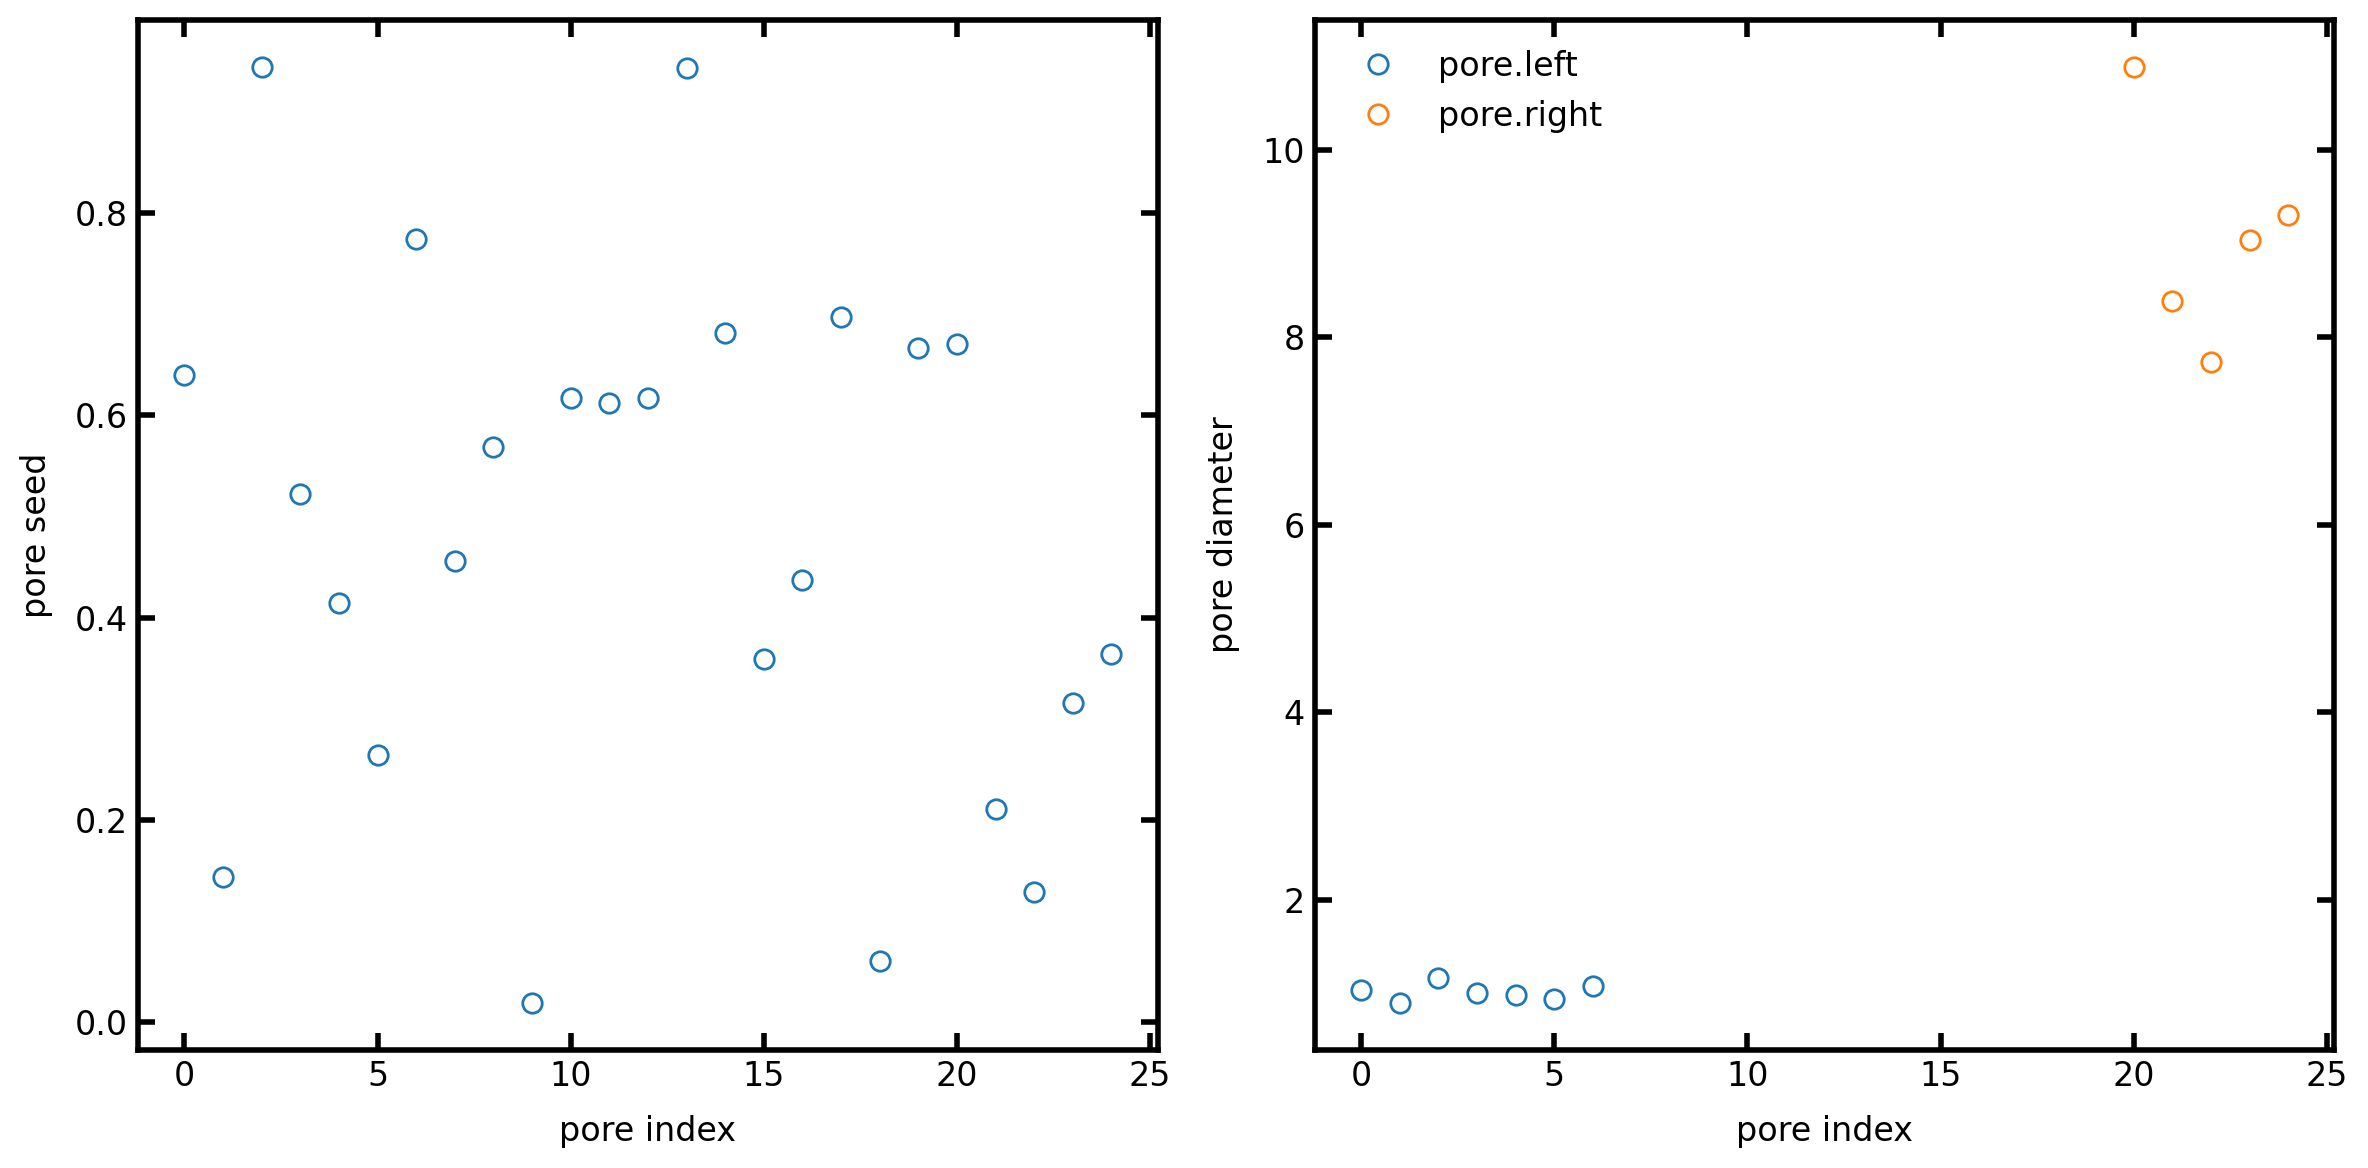

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=[12, 6])

ax[0].plot(pn.Ps, pn['pore.seed'], 'o')
ax[0].set_ylabel('pore seed')
ax[0].set_xlabel('pore index')

ax[1].plot(pn.pores('left'), pn['pore.diameter@left'], 'o', label='pore.left')
ax[1].plot(pn.pores('right'), pn['pore.diameter@right'], 'o', label='pore.right')
ax[1].set_ylabel('pore diameter')
ax[1].set_xlabel('pore index')
ax[1].legend();

And now we can apply a model to the full domain that computes the pore volume, using values of pore diameter that were computed uniquely for each domain:

In [36]:
pn.add_model(propname='pore.volume',
             model=op.models.geometry.pore_volume.sphere)

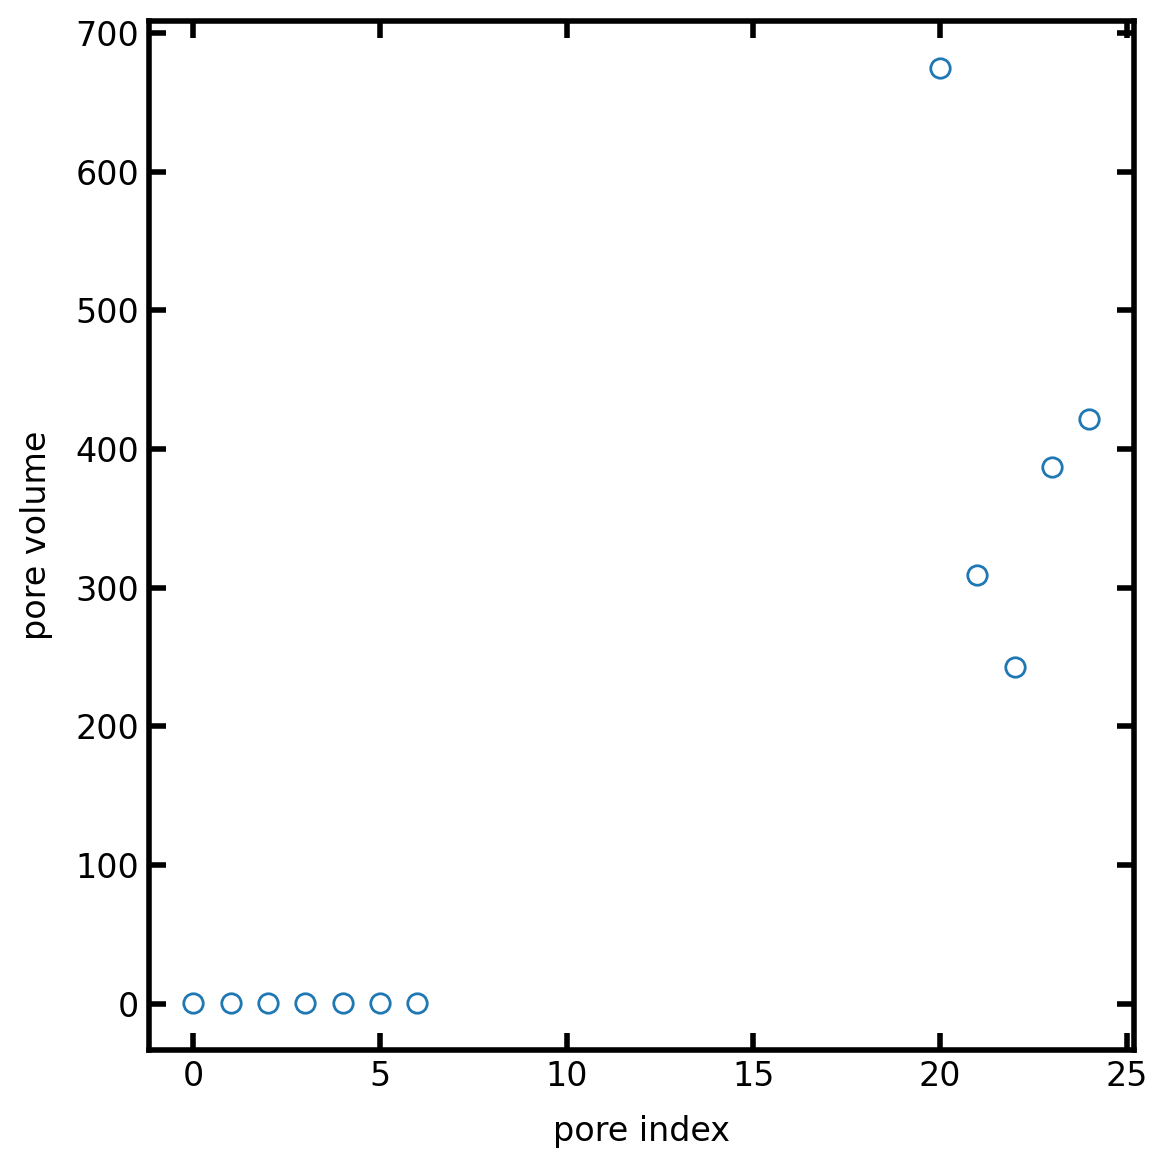

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=[6, 6])

ax.plot(pn.Ps, pn['pore.volume'], 'o')
ax.set_ylabel('pore volume')
ax.set_xlabel('pore index');

### Mixing Many Subdomains of Different Shape
Because subdomains are now very abstract (actually just labels), it is possible to define multiple subdomains with different shape and apply models to each. So far we have added ``'pore.seed'`` and ``'pore.diameter'`` models to the ``'left'`` and ``'right'`` pores.  We can now freely add another set of models to the ``'front'`` and ``'back'``, even though they partially overlap:

In [38]:
Ps = pn.pores(['front', 'back'])
Ts = pn.find_neighbor_throats(Ps, asmask=True)
pn['throat.front'] = Ts
pn['throat.back'] = ~Ts

In [39]:
pn.add_model(propname='throat.diameter',
             model=op.models.geometry.throat_size.from_neighbor_pores,
             domain='front',
             mode='min')
pn.add_model(propname='throat.diameter',
             model=op.models.geometry.throat_size.from_neighbor_pores,
             domain='back',
             mode='max')

Now we can see that the throat diameters have been added to the network:

In [40]:
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Cubic at 0x2359bb72b20>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                       25 / 25
  3  throat.conns                                                      40 / 40
  4  pore.values                                                       25 / 25
  5  pore.new_array                                                     9 / 25
  6  pore.seed                                                         25 / 25
  7  pore.diameter                                                     12 / 25
  8  pore.volume                                                       12 / 25
  9  throat.diameter                                                   40 / 40
――――

```{warning} **Subdomain overlap**

If Subdomains overlap the last model applied 'wins' and overwrites any previous values in its subdomain.
Pore/Throats remain part of all the labels that are applied to them, so care must be taken when working with overlapping subdomains.

```